<a href="https://colab.research.google.com/github/zchuning/BankruptcyDataAnalysis/blob/master/BankruptcyDataAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup and Data Loading



In [128]:
!pip install numpy
!pip install pandas
!pip install scipy
!pip install scikit-learn
!pip install xgboost
!pip install torch torchvision

In [0]:
# Import modules
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from scipy.io import arff

from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, \
GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, accuracy_score, recall_score, \
f1_score, roc_curve, auc

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

### Loading data into collab

1.   Open the file browsing menu by clicking on the tab with a right pointing
arrow.
2.   Navigate to each directories parent until you reach the root.
3.   Upload the .arff file for each year's bankruptcy data. 
4.   Run the code blocks below.



In [0]:
# Load the bankruptcy data into two pandas dataframes
data, meta = arff.loadarff('/2year.arff')
data = np.array(data.tolist(), np.float)

# Extracting X and y
X = data[:, :-1]
y = data[:, -1]

# Data Preparation

## Data Imputation

In [0]:
# Zero imputation function
def zeroImpute(X_miss):
  return np.nan_to_num(X_miss.copy())

In [0]:
# Regression imputation function
def regressedImpute(X_baseImputed, X_miss):
  X_imputed = X_baseImputed.copy()

  for j in range(X_baseImputed.shape[1]):
    # Build model for current column
    selector = [x for x in range(X_baseImputed.shape[1]) if x != j]
    X_filtered = X_baseImputed[~np.isnan(X_miss[:,j])]
    y_filtered = X_filtered[:,j]
    X_filtered = X_filtered[:, selector]
    col_clf = LinearRegression().fit(X_filtered, y_filtered)

    # Replace X_imputed with new values using new model
    for i in range(X_miss.shape[0]):
      if np.isnan(X_miss[i, j]):
        X_imputed[i, j] =\
          col_clf.predict(X_baseImputed[i, selector].reshape(1, -1))
  
  return X_imputed

In [0]:
# Epoch regression imputation
def impute(X_miss, epochs=2):
  X_imputed = zeroImpute(X_miss.copy())
  for _ in range(epochs):
    X_imputed = regressedImpute(X_imputed, X_miss)
  return X_imputed

In [0]:
# Impute data
X_imputed = impute(X)

## Creating Training and Test Sets

In [0]:
# Separate positive and negative samples
X_pos = X_imputed[y == 1]
y_pos = y[y == 1]
X_neg = X_imputed[y == 0]
y_neg = y[y == 0]

In [0]:
# Balance data by undersample majority class
# indices = random.sample(range(1, len(X_neg)-1), 800)
# X_neg = X_neg[indices]
# y_neg = y_neg[indices]

# Split data into training and test sets
pos_split = int(len(y_pos) * 0.7)
neg_split = int(len(y_neg) * 0.7)

X_train = np.concatenate((X_neg[:neg_split], X_pos[:pos_split]))
y_train = np.concatenate((y_neg[:neg_split], y_pos[:pos_split]))
X_train, y_train = shuffle(X_train, y_train)

X_test = np.concatenate((X_neg[neg_split:], X_pos[pos_split:]))
y_test = np.concatenate((y_neg[neg_split:], y_pos[pos_split:]))
X_test, y_test = shuffle(X_test, y_test)

#Utility Functions

In [0]:
# Plot training results
def plot_line_graph(x_vals, y_vals_1, y_vals_2, y_vals_3, y_vals_1_label, \
                    y_vals_2_label, y_vals_3_label, x_axis_label, \
                    y_axis_label, title):

    plt.plot(x_vals, y_vals_1, color='g', label=y_vals_1_label)
    plt.plot(x_vals, y_vals_2, color='orange', label=y_vals_2_label)
    plt.plot(x_vals, y_vals_3, color='b', label=y_vals_3_label)
    plt.xlabel(x_axis_label)
    plt.ylabel(y_axis_label)
    plt.title(title)
    plt.legend(loc='upper right')
    plt.show()

def get_eval_scores(y_test, y_pred):
    acc_score = accuracy_score(y_test, y_pred)
    pre_score = precision_score(y_test, y_pred)
    rec_score = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return acc_score, pre_score, rec_score, f1

# Plot AUC curve
def plot_AUC(y_pred_proba, y_test):
    pos_score = y_pred_proba[:,1]
    fpr, tpr, _ = roc_curve(y_test, pos_score)
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

# K Nearest Neighbors

In [0]:
def knn(X_train, y_train, X_test, y_test):
    K = [1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33]
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    final_pred_proba = None
    
    for i in range(len(K)):
        clf = KNeighborsClassifier(n_neighbors=K[i], p=2, weights="distance")
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        acc_score, pre_score, rec_score, f1 = get_eval_scores(y_test, y_pred)
        accuracies.append(acc_score)
        precisions.append(pre_score)
        recalls.append(rec_score)
        f1_scores.append(f1)

        print('# K: {0}, Precision: {1}, Recall: {2}, F1: {3}'.format(\
            str(K[i]), str(pre_score), str(rec_score), str(f1)))
        
        if (i == len(K) - 1):
            final_pred_proba = clf.predict_proba(X_test)

    plot_line_graph(K, accuracies, precisions, recalls, 'Accuracy', \
                'Precision', 'Recall', 'K', 'score', \
                'Precision and Accuracy vs. Number of Estimators')
    plot_AUC(final_pred_proba, y_test)

# K: 1, Precision: 0.08928571428571429, Recall: 0.08333333333333333, F1: 0.08620689655172413
# K: 3, Precision: 0.2222222222222222, Recall: 0.06666666666666667, F1: 0.10256410256410256
# K: 5, Precision: 0.14285714285714285, Recall: 0.016666666666666666, F1: 0.029850746268656716
# K: 7, Precision: 0.2, Recall: 0.016666666666666666, F1: 0.03076923076923077
# K: 9, Precision: 0.25, Recall: 0.016666666666666666, F1: 0.03125
# K: 11, Precision: 0.16666666666666666, Recall: 0.008333333333333333, F1: 0.015873015873015872
# K: 13, Precision: 0.16666666666666666, Recall: 0.008333333333333333, F1: 0.015873015873015872
# K: 15, Precision: 0.16666666666666666, Recall: 0.008333333333333333, F1: 0.015873015873015872
# K: 17, Precision: 0.2, Recall: 0.008333333333333333, F1: 0.016
# K: 19, Precision: 0.2, Recall: 0.008333333333333333, F1: 0.016
# K: 21, Precision: 0.2, Recall: 0.008333333333333333, F1: 0.016
# K: 23, Precision: 0.2, Recall: 0.008333333333333333, F1: 0.016
# K: 25, Precision: 0.2, Re

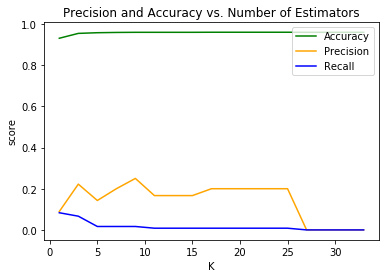

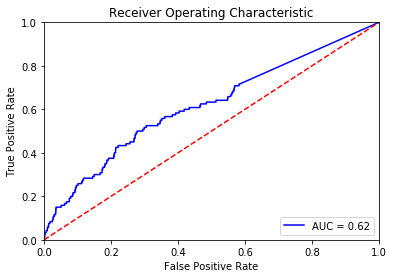

In [0]:
knn(X_train, y_train, X_test, y_test)

#Random Forest


In [0]:
def random_forest(X_train, y_train, X_test, y_test):
    n_estimators = [5, 10, 25, 50, 75, 100, 125, 150]
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    final_pred_proba = None

    for i in range(len(n_estimators)):
        clf = RandomForestClassifier(n_estimators=n_estimators[i], max_depth=6,\
                                     class_weight={0: 1, 1: 25})
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        acc_score, pre_score, rec_score, f1 = get_eval_scores(y_test, y_pred)
        accuracies.append(acc_score)
        precisions.append(pre_score)
        recalls.append(rec_score)
        f1_scores.append(f1)

        print('# Estimators: {0}, Precision: {1}, Recall: {2}, F1: {3}'.format(\
            str(n_estimators[i]), str(pre_score), str(rec_score), str(f1)))

        if (i == len(n_estimators) - 1):
            final_pred_proba = clf.predict_proba(X_test)

    plot_line_graph(n_estimators, accuracies, precisions, recalls, 'Accuracy', \
                'Precision', 'Recall', '# Estimators', 'score', \
                'Precision and Accuracy vs. Number of Estimators')
    plot_AUC(final_pred_proba, y_test)

<<<<TEST DATA PREDICTIONS FOR RANDOM FOREST>>>>
# Estimators: 5, Precision: 0.08702791461412152, Recall: 0.44166666666666665, F1: 0.14540466392318244
# Estimators: 10, Precision: 0.09570957095709572, Recall: 0.48333333333333334, F1: 0.1597796143250689
# Estimators: 25, Precision: 0.13695090439276486, Recall: 0.44166666666666665, F1: 0.20907297830374755
# Estimators: 50, Precision: 0.11447084233261338, Recall: 0.44166666666666665, F1: 0.1818181818181818
# Estimators: 75, Precision: 0.13432835820895522, Recall: 0.45, F1: 0.20689655172413793
# Estimators: 100, Precision: 0.1464088397790055, Recall: 0.44166666666666665, F1: 0.21991701244813275
# Estimators: 125, Precision: 0.1308641975308642, Recall: 0.44166666666666665, F1: 0.20190476190476192
# Estimators: 150, Precision: 0.12556053811659193, Recall: 0.4666666666666667, F1: 0.1978798586572438


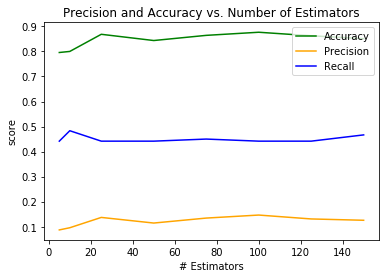

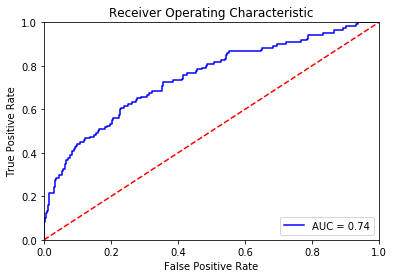

In [0]:
random_forest(X_train, y_train, X_test, y_test)

# Logistic Regression

In [0]:
def logistic_regression(X_train, y_train, X_test, y_test):
    clf = LogisticRegression(solver='lbfgs', class_weight={0: 1, 1: 25}, max_iter=1000)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)

    print('<<<<TEST DATA PREDICTIONS FOR LOGISTIC REGRESSION>>>>')
    acc_score, pre_score, rec_score, f1 = get_eval_scores(y_test, y_pred)
    print('Precision: {0}, Recall: {1}, F1: {2}'.format(str(pre_score), str(rec_score), str(f1)))
    plot_AUC(y_pred_proba, y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


<<<<TEST DATA PREDICTIONS FOR LOGISTIC REGRESSION>>>>
Precision: 0.06063268892794376, Recall: 0.575, F1: 0.109697933227345


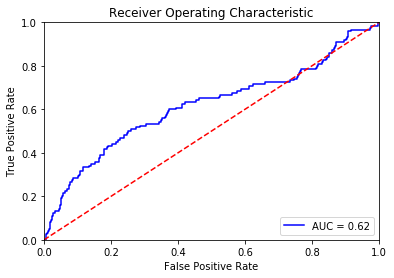

In [0]:
logistic_regression(X_train, y_train, X_test, y_test)

# Support Vector Machine

In [0]:
def svm(X_train, y_train, X_test, y_test):
    clf = SVC(gamma='auto', class_weight={0: 1, 1: 25}, probability=True)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)

    print('<<<<TEST DATA PREDICTIONS FOR LOGISTIC REGRESSION>>>>')
    acc_score, pre_score, rec_score, f1 = get_eval_scores(y_test, y_pred)
    print('Precision: {0}, Recall: {1}, F1: {2}'.format(str(pre_score), str(rec_score), str(f1)))
    plot_AUC(y_pred_proba, y_test)

<<<<TEST DATA PREDICTIONS FOR LOGISTIC REGRESSION>>>>
Precision: 0.0, Recall: 0.0, F1: 0.0


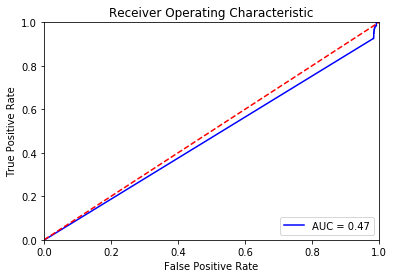

In [0]:
svm(X_train, y_train, X_test, y_test)

# Boosting

## AdaBoost

In [0]:
def adaboost(X_train, y_train, X_test, y_test):
    n_estimators = [50, 100, 150, 200]
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    final_pred_proba = None

    for i in range(len(n_estimators)):
        clf = AdaBoostClassifier(n_estimators=n_estimators[i])
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        acc_score, pre_score, rec_score, f1 = get_eval_scores(y_test, y_pred)
        accuracies.append(acc_score)
        precisions.append(pre_score)
        recalls.append(rec_score)
        f1_scores.append(f1)

        print('# Estimators: {0}, Precision: {1}, Recall: {2}, F1: {3}'.format(\
            str(n_estimators[i]), str(pre_score), str(rec_score), str(f1)))

        if (i == len(n_estimators) - 1):
            final_pred_proba = clf.predict_proba(X_test)

    plot_line_graph(n_estimators, accuracies, precisions, recalls, 'Accuracy', \
                'Precision', 'Recall', '# Estimators', 'score', \
                'Precision and Accuracy vs. Number of Estimators')
    plot_AUC(final_pred_proba, y_test)

# Estimators: 50, Precision: 0.46153846153846156, Recall: 0.15, F1: 0.22641509433962265
# Estimators: 100, Precision: 0.4482758620689655, Recall: 0.21666666666666667, F1: 0.2921348314606742
# Estimators: 150, Precision: 0.43636363636363634, Recall: 0.2, F1: 0.2742857142857143
# Estimators: 200, Precision: 0.4915254237288136, Recall: 0.24166666666666667, F1: 0.3240223463687151


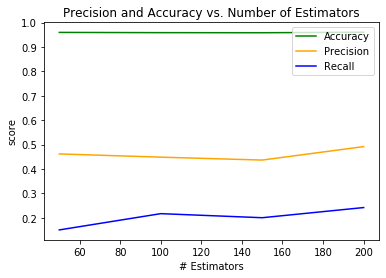

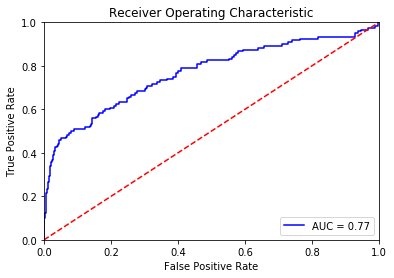

In [0]:
adaboost(X_train, y_train, X_test, y_test)

## Gradient Tree Boosting

In [0]:
def gradient_boosting(X_train, y_train, X_test, y_test):
    n_estimators = [50, 100, 150, 200]
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    final_pred_proba = None

    for i in range(len(n_estimators)):
        clf = GradientBoostingClassifier(n_estimators=n_estimators[i])
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        acc_score, pre_score, rec_score, f1 = get_eval_scores(y_test, y_pred)
        accuracies.append(acc_score)
        precisions.append(pre_score)
        recalls.append(rec_score)
        f1_scores.append(f1)

        print('# Estimators: {0}, Precision: {1}, Recall: {2}, F1: {3}'.format(\
            str(n_estimators[i]), str(pre_score), str(rec_score), str(f1)))

        if (i == len(n_estimators) - 1):
            final_pred_proba = clf.predict_proba(X_test)

    plot_line_graph(n_estimators, accuracies, precisions, recalls, 'Accuracy', \
                'Precision', 'Recall', '# Estimators', 'score', \
                'Precision and Accuracy vs. Number of Estimators')
    plot_AUC(final_pred_proba, y_test)

# Estimators: 50, Precision: 0.6829268292682927, Recall: 0.23333333333333334, F1: 0.3478260869565218
# Estimators: 100, Precision: 0.7291666666666666, Recall: 0.2916666666666667, F1: 0.4166666666666667
# Estimators: 150, Precision: 0.7169811320754716, Recall: 0.31666666666666665, F1: 0.43930635838150284
# Estimators: 200, Precision: 0.7407407407407407, Recall: 0.3333333333333333, F1: 0.4597701149425288


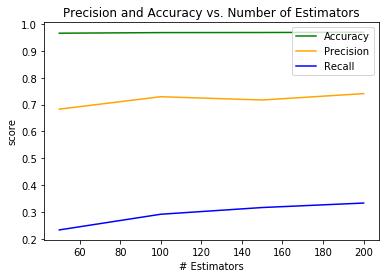

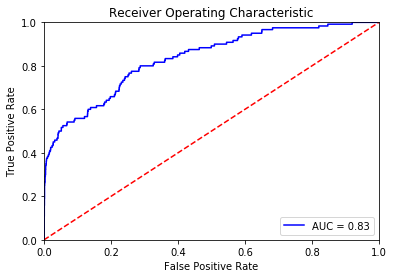

In [0]:
gradient_boosting(X_train, y_train, X_test, y_test)

## Extreme Gradient Boosting

In [0]:
def xgboost(X_train, y_train, X_test, y_test):
    n_estimators = [50, 100, 150, 200]
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    final_pred_proba = None

    for i in range(len(n_estimators)):
        clf = XGBClassifier(n_estimators=n_estimators[i])
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        acc_score, pre_score, rec_score, f1 = get_eval_scores(y_test, y_pred)
        accuracies.append(acc_score)
        precisions.append(pre_score)
        recalls.append(rec_score)
        f1_scores.append(f1)

        print('# Estimators: {0}, Precision: {1}, Recall: {2}, F1: {3}'.format(\
            str(n_estimators[i]), str(pre_score), str(rec_score), str(f1)))

        if (i == len(n_estimators) - 1):
            final_pred_proba = clf.predict_proba(X_test)

    plot_line_graph(n_estimators, accuracies, precisions, recalls, 'Accuracy', \
                'Precision', 'Recall', '# Estimators', 'score', \
                'Precision and Accuracy vs. Number of Estimators')
    plot_AUC(final_pred_proba, y_test)


# Estimators: 50, Precision: 0.8285714285714286, Recall: 0.24166666666666667, F1: 0.3741935483870968
# Estimators: 100, Precision: 0.8, Recall: 0.3, F1: 0.4363636363636363
# Estimators: 150, Precision: 0.7307692307692307, Recall: 0.31666666666666665, F1: 0.44186046511627913
# Estimators: 200, Precision: 0.7307692307692307, Recall: 0.31666666666666665, F1: 0.44186046511627913


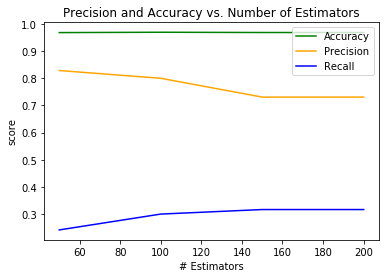

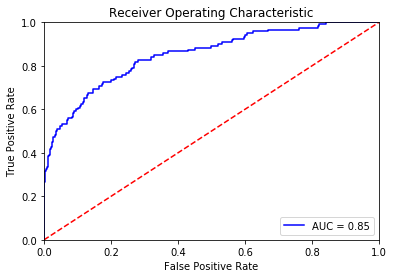

In [95]:
xgboost(X_train, y_train, X_test, y_test)

# Multilayer Perceptron (NN)

In [0]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        num_features = 64
        self.fc1 = nn.Linear(num_features, 8)
        self.fc2 = nn.Linear(8, 1)
    def forward(self, X):
        out = self.fc1(X)
        out = torch.sigmoid(out)
        out = self.fc2(out)
        out = torch.sigmoid(out)
        return out

In [0]:
def train_MLP(num_epochs, X_train, y_train, model, criterion, optimizer):
    loss_curve = []
    X = torch.tensor(X_train)
    y = torch.tensor(y_train).reshape(-1, 1)
    for epoch in range(num_epochs):
        optimizer.zero_grad()

        output = model(X)
        loss = criterion(output, y)
        loss_curve.append(loss.item())

        loss.backward()
        optimizer.step()
    return model, loss_curve

In [0]:
def multilayer_perceptron(X_train, y_train, X_test, y_test):
    num_epochs = 1000
    model = MLP()
    model.double()
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters())

    trained_model, loss_curve = train_MLP(num_epochs, X_train, y_train, model, \
                                          criterion, optimizer)
    
    # Plot training curve
    epochs = np.arange(num_epochs)
    plt.figure()
    plt.plot(epochs,loss_curve,label='size 2')
    plt.title("Loss vs num Epochs for bottleneck layer size 2")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

    # Evaluate on test set
    y_pred_proba = trained_model(torch.tensor(X_test)).data.numpy()
    y_pred = (y_pred_proba > 0.5).astype(int)

    # Get evaluation scores
    acc_score, pre_score, rec_score, f1 = get_eval_scores(y_test, y_pred)
    print('Precision: {0}, Recall: {1}, F1: {2}'.format(str(pre_score), str(rec_score), str(f1)))

    # Plot ROC curve
    y_pred_proba = np.concatenate((np.zeros((len(y_pred_proba), 1)), y_pred_proba), axis = 1)
    plot_AUC(y_pred_proba, y_test)


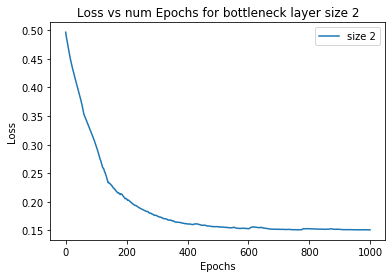

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Precision: 0.0, Recall: 0.0, F1: 0.0


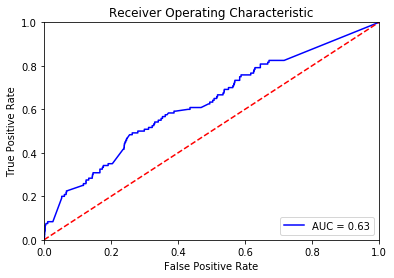

In [177]:
multilayer_perceptron(X_train, y_train, X_test, y_test)